**Problem Statement :** Build Model to automatically identify whether a patient is suffering from Covid 19 or not by looking at X-ray images. The algorithm had to be extremely accurate because lives of people is at high importance.

**Dataset Description :** In this project, we will use the COVID CXR Image Dataset (Research) which consists of a total of 1823 posteroanterior (PA) views of chest X-ray images comprising Normal, Viral, and COVID-19 affected patients.

This dataset is comprisd with 536 Covid-19 images, 619 Viral Pneumonia images, and 668 Normal images.

**Dataset Used : https://www.kaggle.com/datasets/sid321axn/covid-cxr-image-dataset-research**

# **1. Loading Data**

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# **2. Exploratory Data Analysis**

In [ ]:
#importing important libraries
import tensorflow #tensorflow for building and training machine learning models.
from PIL import Image #for Opening, rotating and displaying an image
import glob #To search for files that match a specific file pattern or name
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, save_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization,Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt #matplotlib.pyplot (as plt) for visualization.
import numpy as np #numpy (as np) for numerical operations
from tqdm import tqdm #The tqdm module allows for the generation of progress bars in Python
import cv2 #cv2 for computer vision tasks, including image loading and processing
import os #to interact with the underlying operating system.
import shutil #For automating process of copying and removal of files and directories
import itertools #used to iterate over data structures that can be stepped over using a for-loop.
import imutils #A series of convenience functions to make basic image processing functions
from sklearn.model_selection import StratifiedKFold
import random #For generating or manipulating random integers.
from tensorflow.keras import layers

In [ ]:
# Loading images from Gdrive and creating directory per class
COV_DIR = "/content/drive/My Drive/COVID_IEEE/covid/"
NORM_DIR = "/content/drive/My Drive/COVID_IEEE/normal/"
# VIR_DIR = "/content/drive/My Drive/COVID_IEEE/virus/"

In [ ]:
# function for printing image specification
def Images_details_Print_data(data, path):
    print(" ====== Images in: ", path)
    for k, v in data.items():
        print("%s:\t%s" % (k, v))

In [ ]:
# function for getting image specification details
def Images_details(path):
    files = [f for f in glob.glob(path + "**/*.*", recursive=True)]
    data = {}
    data['images_count'] = len(files)
    data['min_width'] = 10**100  # No image will be bigger than that
    data['max_width'] = 0
    data['min_height'] = 10**100  # No image will be bigger than that
    data['max_height'] = 0
    for f in files:
        im = Image.open(f)
        width, height = im.size
        data['min_width'] = min(width, data['min_width'])
        data['max_width'] = max(width, data['max_height'])
        data['min_height'] = min(height, data['min_height'])
        data['max_height'] = max(height, data['max_height'])
    Images_details_Print_data(data, path)

In [ ]:
# getting specification of Normal images
Images_details(NORM_DIR)

 ====== Images in:  /content/drive/My Drive/COVID_IEEE/normal/
images_count:	668
min_width:	1040
max_width:	2628
min_height:	650
max_height:	2628


In [ ]:
# getting specification of COVID-19 images
Images_details(COV_DIR)

 ====== Images in:  /content/drive/My Drive/COVID_IEEE/covid/
images_count:	536
min_width:	240
max_width:	3520
min_height:	237
max_height:	4095


# **Plotting Sample Images**

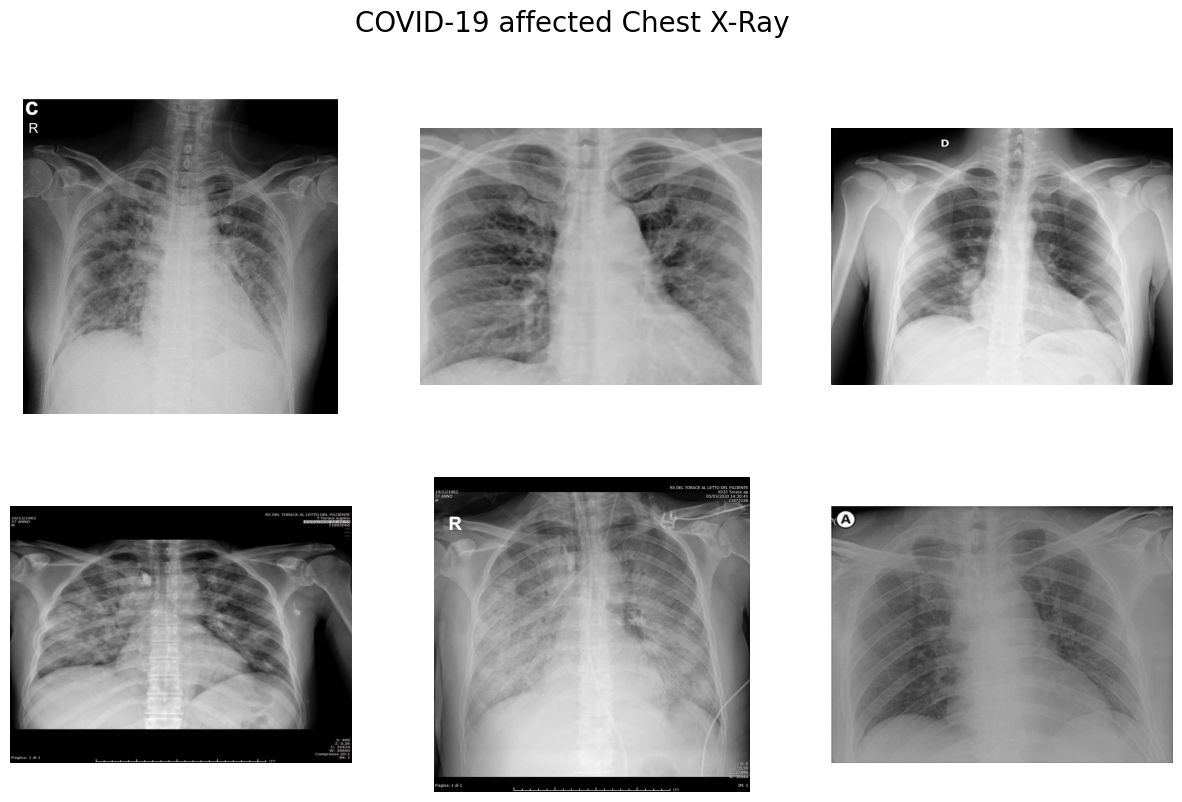

In [ ]:
# Getting the list of images for each class for future use
Cimages = os.listdir(COV_DIR)
Nimages = os.listdir(NORM_DIR)
#Vimages = os.listdir(VIR_DIR)
# plotting sample images of COVID-19
sample_images = random.sample(Cimages,6)
f,ax = plt.subplots(2,3,figsize=(15,9))
for i in range(0,6):
    im = cv2.imread('/content/drive/My Drive/COVID_IEEE/covid/'+sample_images[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('COVID-19 affected Chest X-Ray',fontsize=20)
plt.show()

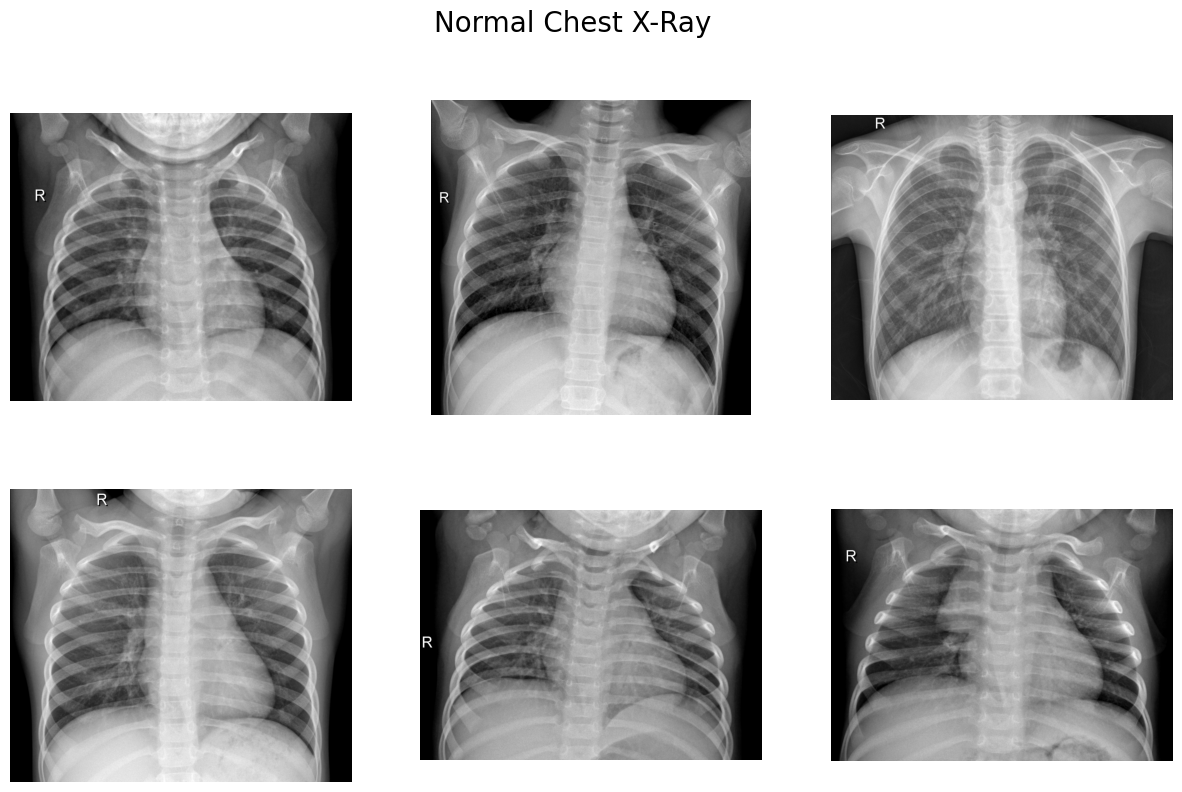

In [ ]:
# plotting sample images of Normal
sample_nimages = random.sample(Nimages,6)
f,ax = plt.subplots(2,3,figsize=(15,9))
for i in range(0,6):
    im = cv2.imread('/content/drive/My Drive/COVID_IEEE/normal/'+sample_nimages[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Normal Chest X-Ray',fontsize=20)
plt.show()

# **3. Data Loading & Image Pre-processing**

## **White balance**

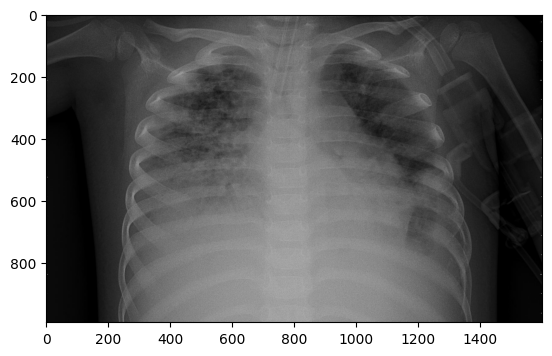

In [ ]:
# Loading Original Image
img = cv2.imread('/content/drive/My Drive/COVID_IEEE/virus/person1661_virus_2872.jpeg')
plt.imshow(img, cmap=plt.cm.bone)

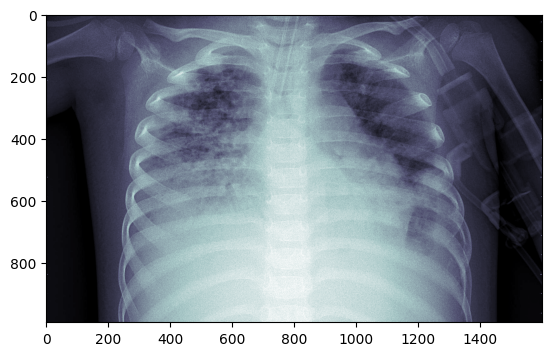

In [ ]:
# white balance for every channel independently
def wb(channel, perc = 0.05):
    mi, ma = (np.percentile(channel, perc), np.percentile(channel,100.0-perc))
    channel = np.uint8(np.clip((channel-mi)*255.0/(ma-mi), 0, 255))
    return channel
imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(img)] )
# Convert image to grayscale
gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image, cmap=plt.cm.bone)

## **Data Loading**

In [ ]:
data=[]
labels=[]
Normal=os.listdir("/content/drive/My Drive/COVID_IEEE/normal/")
for a in Normal:
    # extract the class label from the filename

    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread("/content/drive/My Drive/COVID_IEEE/normal/"+a)
        # performing white balance
    imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)] )
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(img, (224, 224))
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(0)
Covid=os.listdir("/content/drive/My Drive/COVID_IEEE/covid/")
for b in Covid:
    # extract the class label from the filename

    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread("/content/drive/My Drive/COVID_IEEE/covid/"+b)
        # performing white balance
    imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)] )
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)

    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(img, (224, 224))
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(1)


In [ ]:
#converting features and labels in array
feats=np.array(data)
labels=np.array(labels)

In [ ]:
# saving features and labels for later re-use
np.save("/content/drive/My Drive/COVID_IEEE/feats_train",feats)
np.save("/content/drive/My Drive/COVID_IEEE/labels_train",labels)

## **Loading images from Numpy arrays**

In [ ]:
# loading images
feats=np.load("/content/drive/My Drive/COVID_IEEE/feats_train.npy")
labels=np.load("/content/drive/My Drive/COVID_IEEE/labels_train.npy")

In [ ]:
# randomizing the order of image and labels data
s=np.arange(feats.shape[0])
np.random.shuffle(s)
feats=feats[s]
labels=labels[s]

In [ ]:
# retaining length of the data and number of classes
num_classes=len(np.unique(labels))
len_data=len(feats)
print(len_data)

1204


# **3. Train Test Split**

In [ ]:
# splitting cells images into 80:20 ratio i.e., 80% for training and 20% for testing purpose
(x_train,x_test)=feats[(int)(0.2*len_data):],feats[:(int)(0.2*len_data)]
(y_train,y_test)=labels[(int)(0.2*len_data):],labels[:(int)(0.2*len_data)]

# **4. Image Normalization**

In [ ]:
x_train = x_train.astype('float32')/255 # As we are working on image data we are normalizing data by dividing 255.
x_test = x_test.astype('float32')/255
train_len=len(x_train)
test_len=len(x_test)

In [ ]:
from keras.utils import to_categorical
y_train=to_categorical(y_train,2)
y_test=to_categorical(y_test,2)

# **5. Image Augmentation**

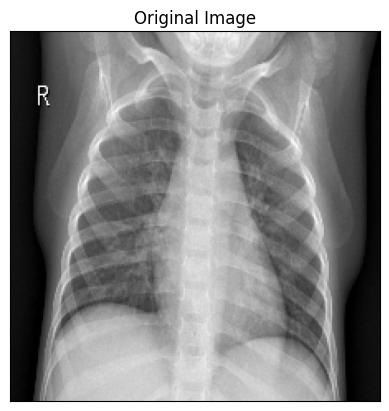

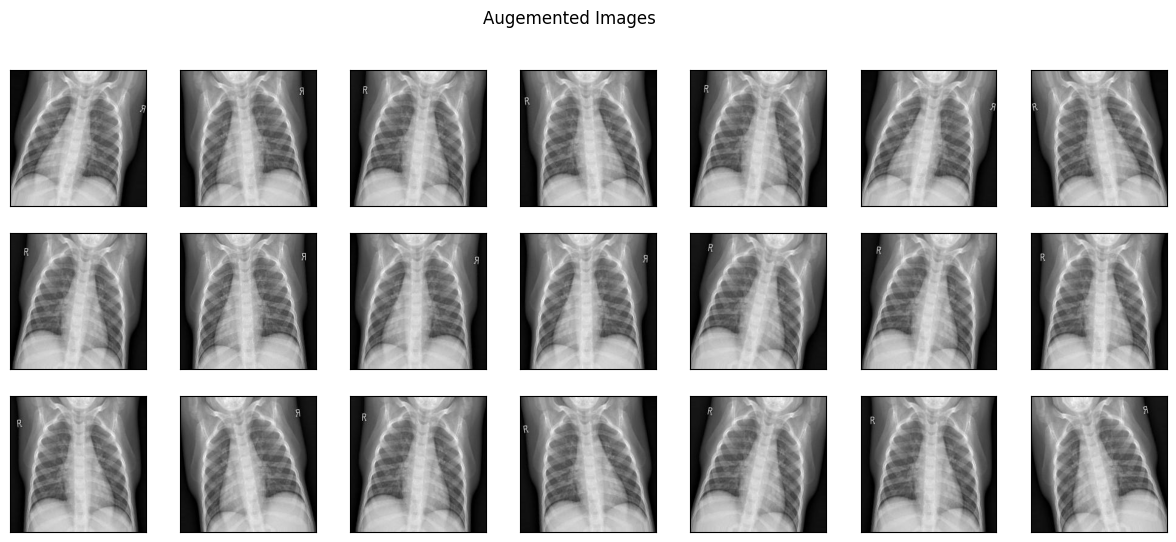

In [ ]:
trainAug  = ImageDataGenerator(
    rotation_range=15,

    horizontal_flip=True,
    fill_mode="nearest")
# demo augmentation
# set the paramters we want to change randomly
os.mkdir('preview_5')
x = x_train[1]
x = x.reshape((1,) + x.shape)
i = 0
for batch in trainAug.flow(x, batch_size=1, save_to_dir='preview_4', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 30:
        break
plt.imshow(x_train[1])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()
plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview_4/'):
    img = cv2.imread('preview_4/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

# **6. Model building**

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
conv_base = MobileNetV2(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet')
for layer in conv_base.layers:
    layer.trainable = True

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(units=32, activation='relu')(x)
x = Dropout(rate=0.3)(x)
predictions = layers.Dense(2, activation='softmax')(x)
model = Model(conv_base.input, predictions)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# setting call back function
callbacks = [ModelCheckpoint('.mdl_wts_mobilenetv2.hdf5', monitor='val_loss',mode='min',verbose=1, save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1, mode='min', min_lr=0.00000000001)]

## **Model fitting**

In [ ]:
# batch size
BS = 16
print("[INFO] training head...")
H = model.fit(
    trainAug.flow(x_train,y_train, batch_size=BS),
    steps_per_epoch=train_len // BS,
    validation_data=(x_test, y_test),
    validation_steps=test_len // BS,
    epochs=50,callbacks=callbacks)

[INFO] training head...
Epoch 1/50
60/60 [==============================] - ETA: 0s - loss: 0.0147 - accuracy: 0.9947
Epoch 1: val_loss did not improve from 1.42222
60/60 [==============================] - 254s 4s/step - loss: 0.0147 - accuracy: 0.9947 - val_loss: 1.8811 - val_accuracy: 0.8958 - lr: 2.7000e-05
Epoch 2/50
60/60 [==============================] - ETA: 0s - loss: 0.0372 - accuracy: 0.9958
Epoch 2: val_loss did not improve from 1.42222
60/60 [==============================] - 252s 4s/step - loss: 0.0372 - accuracy: 0.9958 - val_loss: 1.6071 - val_accuracy: 0.9125 - lr: 2.7000e-05
Epoch 3/50
60/60 [==============================] - ETA: 0s - loss: 0.0311 - accuracy: 0.9926
Epoch 3: val_loss did not improve from 1.42222
60/60 [==============================] - 250s 4s/step - loss: 0.0311 - accuracy: 0.9926 - val_loss: 1.5599 - val_accuracy: 0.9167 - lr: 2.7000e-05
Epoch 4/50
60/60 [==============================] - ETA: 0s - loss: 0.0157 - accuracy: 0.9979
Epoch 4: val_loss 

# **7. Model Evaluation**

15/15 [==============================] - 28s 2s/step


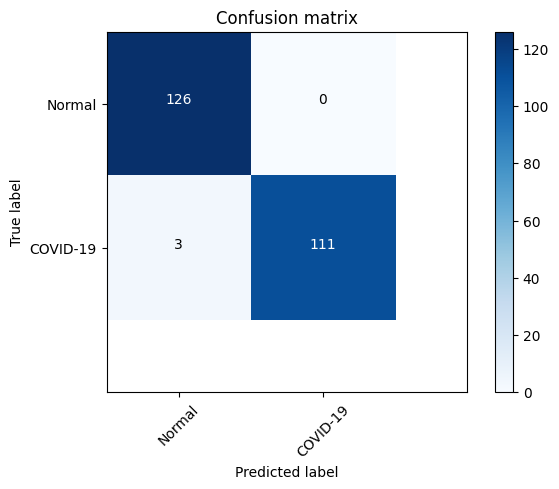

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    target_names =['Normal','COVID-19']

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
pred_Y = model.predict(x_test, batch_size = 16, verbose = True)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(pred_Y,axis=1)
# Convert validation observations to one hot vectors
# compute the confusion matrix
rounded_labels=np.argmax(y_test, axis=1)
confusion_mtx = confusion_matrix(rounded_labels, Y_pred_classes)



# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))

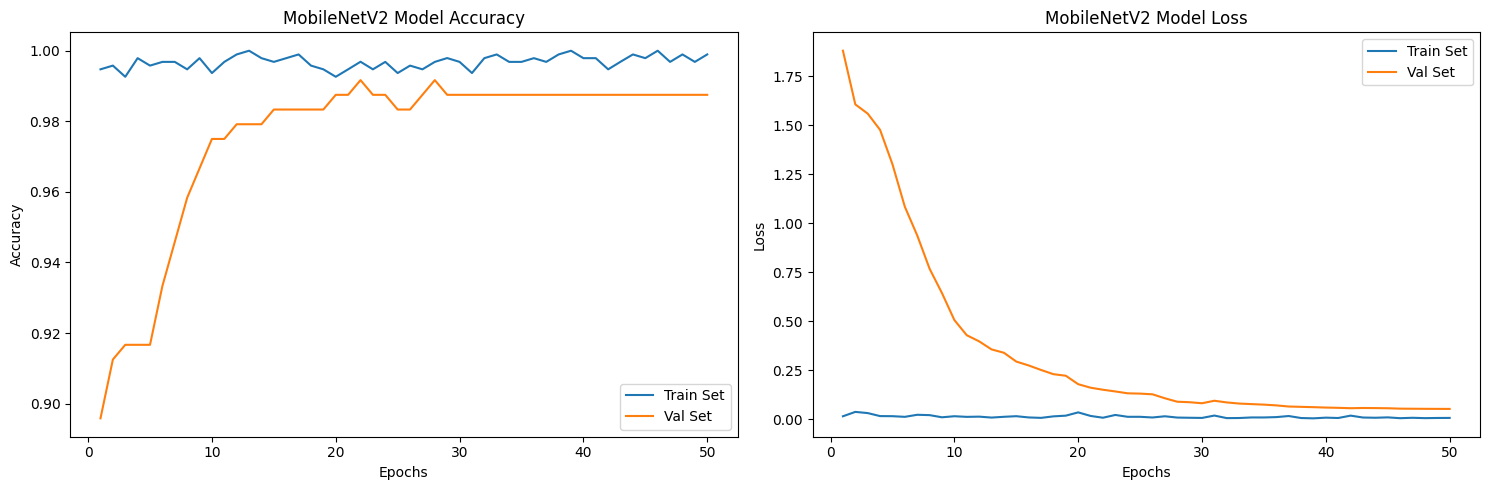

In [ ]:
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs_range = range(1, len(H.epoch) + 1)
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('MobileNetV2 Model Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MobileNetV2 Model Loss')
plt.tight_layout()
plt.show()

# Saving our model in google drive for further use.

In [ ]:
model = tensorflow.keras.saving.load_model('.mdl_wts_mobilenetv2.hdf5')
model.save('/content/drive/My Drive/COVID_IEEE/model_v1.h5')
model = tensorflow.keras.saving.load_model('/content/drive/My Drive/COVID_IEEE/model_v1.h5')
# checking the accuracy
accuracy = model.evaluate(x_test, y_test, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1]).

8/8 [==============================] - 12s 1s/step - loss: 0.0523 - accuracy: 0.9875

 Test_Accuracy:- 0.987500011920929
